In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import tree
import sklearn.linear_model as LM
from sklearn import ensemble
from sklearn.datasets import make_classification,make_circles,make_regression
from sklearn.metrics import zero_one_loss,r2_score,mean_squared_error

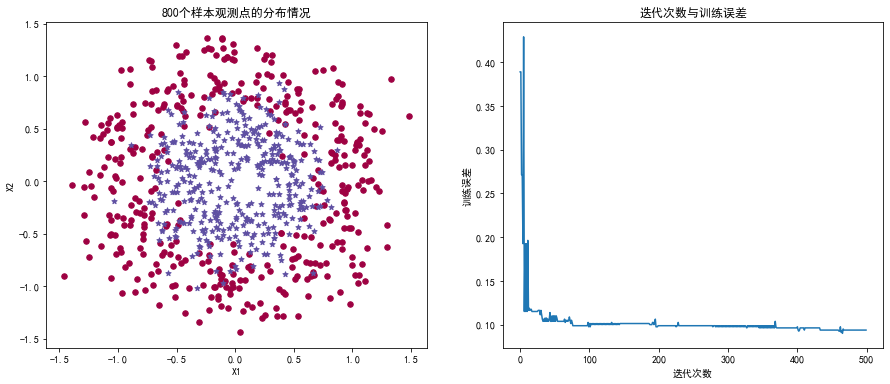

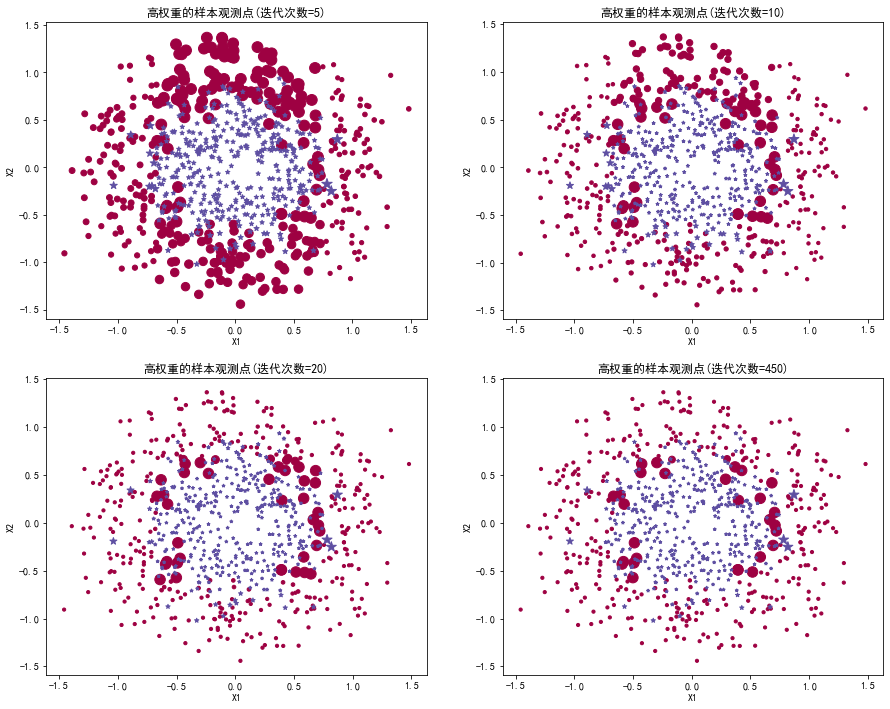

In [2]:
N=800
X,Y=make_circles(n_samples=N,noise=0.2,factor=0.5,random_state=123)
unique_lables=set(Y)
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
colors=plt.cm.Spectral(np.linspace(0,1,len(unique_lables)))
markers=['o','*']
for k,col,m in zip(unique_lables,colors,markers):
    x_k=X[Y==k]
    #plt.plot(x_k[:,0],x_k[:,1],'o',markerfacecolor=col,markeredgecolor="k",markersize=8)
    axes[0].scatter(x_k[:,0],x_k[:,1],color=col,s=30,marker=m)
axes[0].set_title('%d个样本观测点的分布情况'%N)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
B=500
adaBoost = ensemble.AdaBoostClassifier(base_estimator=dt_stump,n_estimators=B,algorithm="SAMME",random_state=123)
adaBoost.fit(X,Y)
adaBoostErr = np.zeros((B,))
for b,Y_pred in enumerate(adaBoost.staged_predict(X)):
    adaBoostErr[b] = zero_one_loss(Y,Y_pred)
axes[1].plot(np.arange(B),adaBoostErr,linestyle='-')
axes[1].set_title('迭代次数与训练误差')
axes[1].set_xlabel('迭代次数')
axes[1].set_ylabel('训练误差')

fig = plt.figure(figsize=(15,12))
data=np.hstack((X.reshape(N,2),Y.reshape(N,1)))
data=pd.DataFrame(data)
data.columns=['X1','X2','Y']
data['Weight']=[1/N]*N
for b,Y_pred in enumerate(adaBoost.staged_predict(X)):
    data['Y_pred']=Y_pred        
    data.loc[data['Y']!=data['Y_pred'],'Weight'] *= (1.0-adaBoost.estimator_errors_[b])/adaBoost.estimator_errors_[b]
    if b in [5,10,20,450]:        
        axes = fig.add_subplot(2,2,[5,10,20,450].index(b)+1) 
        for k,col,m in zip(unique_lables,colors,markers):
            tmp=data.loc[data['Y']==k,:]
            tmp['Weight']=10+tmp['Weight']/(tmp['Weight'].max()-tmp['Weight'].min())*100
            axes.scatter(tmp['X1'],tmp['X2'],color=col,s=tmp['Weight'],marker=m) 
            axes.set_xlabel('X1')
            axes.set_ylabel('X2')
            axes.set_title("高权重的样本观测点(迭代次数=%d)"%b)

            

说明：这里基于模拟数据直观观察提升策略下高权重样本观测随迭代次数的变化情况。
1、利用make_circles生成样本量等于800，有两个输入变量，输出变量为二分类的数据集。图形显示两分类的边界大致呈圆形。
2、以树深度等于1的分类树为基础学习器，采用提升策略进行集成学习。随迭代次数的增加，前期训练误差快速下降，大约30次后下降不明显并保持在一个基本稳定的水平。
3、为探索迭代过程中高权重样本观测的变化情况，计算每次迭代后各个样本观测的权重。
4、以点的大小展示迭代5次，10次，20次和450次时样本观测的权重大小。高权重（预测误差）的样本观测主要集中在两类的圆形边界上。